<center><p float="center">
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10> Generative AI for NLP Program</center></font></h1>
<h1><center> Project </center></h1>

# **GA-NLP Mid-Term Project: Financial Product Complaint Classification and Summarization**

## **Business Context**

In today's financial landscape, customer complaints are pivotal for financial institutions, highlighting areas of dissatisfaction and guiding business improvements. The intricate task of classifying these complaints into specific product categories is crucial for understanding customer issues and enhancing service delivery. By employing Generative AI for text classification, businesses can gain a detailed understanding of customer grievances related to various financial products such as credit reports, student loans, and money transfers.

The integration of machine learning algorithms has revolutionized the automation of customer complaint classification. Utilizing these advanced techniques, financial institutions can swiftly and accurately categorize new complaints based on their content. This automation not only saves time and resources but also ensures timely responses to customer issues, thereby improving customer satisfaction and compliance with regulatory standards.

Additionally, this project will explore the summarization of customer narratives to provide more personalized solutions to complaints. By using Generative AI, businesses can enhance their ability to classify complaints more precisely and generate complaint summaries that facilitate more tailored and effective service responses.

Embarking on this project of Financial Product Complaint Classification and Summarization, with a focus on classification and summarization accuracy, equips you with essential skills applicable to real-world business contexts. Through hands-on experience with code and implementation specifics, you'll gain the proficiency to build such solutions using open-source machine learning algorithms. This experience will serve as a compelling Proof-of-Concept, paving the way for the implementation of these advanced solutions in financial institutions.

## **Project Objective**

Develop a Generative AI application using a Large Language Model to automate product classification and narrative summarization. This application will predict product categories, generate responses based on customer sentiment, and summarize narratives for the mediation team. We have been tackling this task with BERT and prompt engineering with LLMs. We will explore various techniques and select the most effective method.

# **Section 1 BERT Fine Tuning (10 Marks)** (product classification)

### **Question 1: Installing the necessary packages and importing libraries (1 Mark)**

In [ ]:
# Import necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import modules from scikit-learn for machine learning tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report

# Import TensorFlow for deep learning tasks
import tensorflow as tf

import re
import json

In [ ]:
# Import BertTokenizer, TFBertForSequenceClassification from the Hugging Face transformers library
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
# Set the seed for the TensorFlow random number generator to ensure reproducibility
tf.random.set_seed(42)

### **Question 2: Data preprocessing for Bert Fine Tuning (2 Marks)**

In [ ]:
# Load a CSV File containing Dataset of 500 products, narrative and summary (summary of narrative)
data=pd.read_csv("./Complaints_classification.csv")

In [ ]:
data.shape

In [ ]:
data.head()

#### Observations:
- product column is categorical
- narrative text is already all lower case and needs no cleaning.
- summary is mixed-case, may need cleaning later

In [ ]:
#Bert_data=data['product','narrative']

In [ ]:
# Creating dependent and independent variables from Bert_data
train_test = data['narrative']
y = data['product']
# Further split the temporary set into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(train_test, y, test_size=0.20, stratify=y, random_state=42)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
# Label Encoding
encoder = LabelEncoder()

# fit the encoder to the training labels
y_train_enc = encoder.fit_transform(y_train)

# applying the encoder mapping from training labels to test labels
y_test_enc = encoder.transform(y_test)

### **Question 3: Tokenization (1 Mark)**

In [ ]:
# loading and creating an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# specifying the maximum length of the input 512
max_length = 512

In [ ]:
X_train_tokenized = tokenizer(
    X_train.values.tolist(),    # passing the data as a list to the tokenizer
    max_length=max_length,    # specifies the maximum length of the tokenized data
    padding='max_length',    # padding the data to the specified maximum length
    truncation=True,    # truncating the input if it is longer than the specified maximum length
    return_attention_mask=True,    # specifying to return attention masks
    return_tensors='tf',    # specifying to return the output as tensorflow tensors
)
X_test_tokenized = tokenizer(
    X_test.values.tolist(),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf',
)

In [ ]:
type(X_train_tokenized)

### **Question 4: Creating Tensorflow dataset (1 Mark)**

In [ ]:
# defining the size of the batches
batch_size = 8

# convert the tokenized input and the output into a batched tensorflow dataset for training
train_tokenized_tf = tf.data.Dataset.from_tensor_slices((dict(X_train_tokenized), y_train_enc)).batch(batch_size)

# convert the tokenized input and the output into a batched tensorflow dataset for testing
test_tokenized_tf = tf.data.Dataset.from_tensor_slices((dict(X_test_tokenized), y_test_enc)).batch(batch_size)

### **Question 5 Evaluating the base model's performance in product classification.(1 Marks)**

In [ ]:
def bert_f1_score(actual_vals, pred_vals):
    micro_f1_score = f1_score(actual_vals, pred_vals, average="micro")
    return micro_f1_score

In [ ]:
# Actual product class
actual_val = np.concatenate([y for x, y in test_tokenized_tf], axis=0)

In [ ]:
num_classes = y.nunique()
num_classes

In [ ]:
# Initialize Model using BERT for sequence classification
base_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

In [ ]:
# print the summary of the model
base_model.summary()

In [ ]:
# Make prediction on test_tokenized_tf
preds_raw_test = base_model.predict(test_tokenized_tf)
preds_test_base = np.argmax(np.array(tf.nn.softmax(preds_raw_test.logits)), axis=1)
preds_test_base.shape

In [ ]:
preds_test_base[0:5]

In [ ]:
y_test_enc[0:5]

In [ ]:
y_test.value_counts()

In [ ]:
data['product'].value_counts()

In [ ]:
# Evaluate bert base model
base_f1_score = bert_f1_score(y_test_enc, preds_test_base)
print(base_f1_score)

#### Observations:
- Untrained model performance is really bad.

### **Question 6 Fine-Tuning Bert Model on training set (2 Marks)**

In [ ]:
num_classes = y.nunique()
# Model initialization using BERT for sequence classification
ft_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

In [ ]:
# setting the learning rate for the optimizer
learning_rate = 1e-5

# Setting the optimizer to Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# Specify the loss function for the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define evaluation metric(s) for the model
metric = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model with the chosen optimizer, loss function, and metrics
ft_model.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
# Calculate class weights for imbalanced dataset
cw = (y_train_enc.shape[0]) / np.bincount(y_train_enc)

# Create a dictionary mapping class indices to their respective class weights
cw_dict = {}
for i in range(cw.shape[0]):
    cw_dict[encoder.transform(encoder.classes_)[i]] = cw[i]

In [ ]:
# Number of training epochs
n_epochs = 1
#train bert model
bert_base_tuned = ft_model.fit(train_tokenized_tf, epochs=n_epochs, class_weight=cw_dict)

### **Question 7. Evaluating the trained model performance (1 Mark)**

In [ ]:
# Generate raw predictions on the test dataset using the trained model
preds_raw_val_ft = ft_model.predict(test_tokenized_tf)

# Extract predicted labels by finding the index with the highest probability for each example
preds_val_ft = np.argmax(np.array(tf.nn.softmax(preds_raw_val_ft.logits)), axis=1)

In [ ]:
preds_val_ft[0:5]

In [ ]:
# Evaluate bert trained model
ft_f1_score = bert_f1_score(y_test_enc, preds_val_ft)
print(ft_f1_score)

### **Question 8: Write your observations (1 Mark)**

- Training improved f1 score dramatically, from 0.09 to 0.60

# **Section 2: Install Libraries for Prompt Engineering and Setting up Mistral Model (3 Marks)**

### **Question 9: Install necessary libraries (1 Mark)**

In [48]:
# Installation for GPU llama_cpp_python==0.2.28
!pip list | grep llama_cpp_python
# For downloading the models from HF Hub huggingface-hub==0.23.2
!pip list | grep huggingface-hub
# install evaluate==0.4.2 and bert-score==0.3.13 using pip command
!pip list | grep evaluate
!pip list | grep bert-score
# install numpy==1.25.2
!pip list | grep numpy

llama_cpp_python             0.2.84
huggingface-hub              0.24.2
evaluate                     0.4.1
bert-score                   0.3.12
numpy                        1.25.2


In [49]:
# Basic Imports for Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import re

import torch
import evaluate

#from google.colab import drive
import locale

In [50]:
# Load a CSV File containing Dataset of 500 products, narrative and summary (summary of narrative)
data=pd.read_csv("./Complaints_classification.csv")

### **Question 10: Importing Libaries and Setting up Mistral Model (2 Marks)**

https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/blob/main/mistral-7b-instruct-v0.2.Q5_K_M.gguf

In [51]:
## Import Hf_hub_download from hugging_face_hub
!ls /home/ubuntu/models

## Import Llama from llama_cpp
from llama_cpp import Llama

llama-2-13b-chat.Q5_K_M.gguf  mistral-7b-instruct-v0.2.Q5_K_M.gguf


In [52]:
# Define the model name or path as a string (You can find this info from hugging face website) Use Mistral

model_basepath = "/home/ubuntu/models/"

# Define the model name as a string, indicating it's in the gguf format

model_name = "mistral-7b-instruct-v0.2.Q5_K_M.gguf" # the model is in gguf format

In [53]:
model_path = model_basepath+model_name

In [54]:
# Create an instance of the 'Llama' class with specified parameters
# remove the blank spaces and complete the code

lcpp_llm = Llama(
        model_path=model_path,
        n_threads=2,  # CPU cores
        n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
        n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
        n_ctx=4096,  # Context window
    )

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /home/ubuntu/models/mistral-7b-instruct-v0.2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   

# **Section 3: Text to Label (12 Marks)**

## **Zero-Shot Prompting (6 Marks)**

### **Q11: Define the Prompt Template, System Message, generate_prompt** **(3 Marks)**

Define a **system message** as a string and assign it to the variable system_message to generate product class.

Create a **zero shot prompt template** that incorporates the system message and user input.

Define **generate_prompt** function that takes both the system_message and user_input as arguments and formats them into a prompt template


Write a Python function called **generate_mistral_response** that takes a single parameter, narrative, which represents the user's complain. Inside the function, you should perform the following tasks:


- **Combine the system_message and narrative to create a prompt string using generate_prompt function.**

*Generate a response from the Mistral model using the lcpp_llm instance with the following parameters:*

- prompt should be the combined prompt string.
- max_tokens should be set to 1200.
- temperature should be set to 0.
- top_p should be set to 0.95.
- repeat_penalty should be set to 1.2.
- top_k should be set to 50.
- stop should be set as a list containing '/s'.
- echo should be set to False.
Extract and return the response text from the generated response.

Don't forget to provide a value for the system_message variable before using it in the function.

In [7]:
system_message = """You are an AI evaluating the input text below to generate a singular product classification.
Be concise.  Do not provide any explanation. Respond only with the product classification.
A product classification is exactly one of:
- credit_card
- retail_banking
- credit_reporting
- mortgages_and_loans
- debt_collection
"""

In [8]:
zero_shot_prompt_template = "{input}"

In [9]:
# Define function that combines user_prompt and system_message to create the prompt
def generate_prompt(_system_message, _user_input):
    _prompt = f"[INST]\n<<SYS>>\n{_system_message}\n<<SYS>>\n{_user_input}\n[/INST]"
    return _prompt

In [11]:
print(generate_prompt(system_message, "this is the user input"))

[INST]
<<SYS>>
You are an AI evaluating the input text below to generate a singular product classification.
Be concise.  Do not provide any explanation. Respond only with the product classification.
A product classification is exactly one of:
- credit_card
- retail_banking
- credit_reporting
- mortgages_and_loans
- debt_collection

<<SYS>>
this is the user input
[/INST]


In [12]:
def generate_mistral_response(_sys_message, input_text):

    # Combine user_prompt and system_message to create the prompt
    prompt=generate_prompt(_sys_message, input_text)
    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1200,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['/s'],
        echo=False
    )

    # Extract and return the response text
    response_text = response["choices"][0]["text"]
    return response_text

**Due to limited GPU resources, we will test our model with zero prompts on only 50 examples instead of the entire dataset.**

In [13]:
# Randomly select 50 rows
new_data = data.sample(n=50, random_state=42)

### **Q12: Create a new column in the DataFrame called 'mistral_response' and populate it with responses generated by applying the 'generate_mistral_response' function to each 'narrative' in the DataFrame and prepare the mistral_response_cleaned column using extract_category function** **(1 Marks)**

In [14]:
# capture lengthy model timing output to variable
%%capture gen_out
new_data['mistral_response'] = new_data['narrative'].apply(lambda x: generate_mistral_response(system_message, zero_shot_prompt_template.format(input=x)))


llama_print_timings:        load time =     633.27 ms
llama_print_timings:      sample time =       2.46 ms /     5 runs   (    0.49 ms per token,  2030.04 tokens per second)
llama_print_timings: prompt eval time =     632.69 ms /   512 tokens (    1.24 ms per token,   809.25 tokens per second)
llama_print_timings:        eval time =     134.96 ms /     5 runs   (   26.99 ms per token,    37.05 tokens per second)
llama_print_timings:       total time =     773.08 ms /   517 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     633.27 ms
llama_print_timings:      sample time =       4.66 ms /     9 runs   (    0.52 ms per token,  1932.99 tokens per second)
llama_print_timings: prompt eval time =      60.88 ms /    33 tokens (    1.84 ms per token,   542.06 tokens per second)
llama_print_timings:        eval time =     208.78 ms /     8 runs   (   26.10 ms per token,    38.32 tokens per second)
llama_print_timings:       total time =     279.02 ms /    41 

In [15]:
new_data['mistral_response'].value_counts()

mistral_response
credit_reporting                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     27
debt_collection                                                                                                                                                                                                                

In [40]:
def extract_category(text):
    # Define the regex pattern to match "category:" or "Category:" followed by a word
    pattern = r'category:\s*(\w+)'  # The pattern itself remains the same

    # Use re.search with the re.IGNORECASE flag to make it case-insensitive
    match = re.search(pattern, text, re.IGNORECASE)

    # If a match is found, return the captured group, else return None
    if match:
        return match.group(1)
    else:
        pattern1 = r'(credit_card|retail_banking|credit_reporting|mortgages_and_loans|debt_collection)'
        match = re.search(pattern1, text.replace('\_','_'), re.IGNORECASE) # strip out random backslashes before '_'
        if match:
            return match.group()
        else:
            print("\nNo match: ", text)
            return ''

In [17]:
# example - new_data['mistral_response_cleaned'] = new_data['narrative'].apply(lambda x:______ )
new_data['mistral_response_cleaned'] = new_data['mistral_response'].apply(lambda x: extract_category(x))

No match:   Based on the input text, it appears to be discussing a vehicle sale transaction. However, there are no clear indications of specific product classifications such as credit cards, retail banking, credit reporting, mortgages and loans, or debt collection. Therefore, I cannot provide a definitive product classification based on this text alone.

However, if we had to make an educated guess based on the context, it seems that this transaction may involve some elements of both retail banking (sale of used vehicle) and possibly mortgages and loans (mention of existing lease deal and payoff amount). But without more information, it's difficult to be certain.

Therefore, I cannot provide a definitive product classification based on the given text.


In [18]:
new_data['product'].value_counts()

product
credit_reporting       37
credit_card             5
mortgages_and_loans     4
retail_banking          3
debt_collection         1
Name: count, dtype: int64

In [22]:
new_data['mistral_response_cleaned'].value_counts().shape[0]

6

### **Q14: Calculate the F1 score** **(1 Marks)**

In [23]:
# Calculate F1 score for 'product' and 'mistral_response'
f1_1 =  f1_score(new_data['product'], new_data['mistral_response'], average="micro")
print(f'F1 Score: {f1_1}')

F1 Score: 0.0


In [24]:
# Calculate F1 score for 'product' and 'mistral_response_cleaned'
f1_2 =  f1_score(new_data['product'], new_data['mistral_response_cleaned'], average="micro")
print(f'F1 Score: {f1_2}')

F1 Score: 0.8


### **Q15: Explain the difference in F1 scores between mistral_response and mistral_response_cleaned.** **(1 Marks)**

The F1 score is zero for the raw Mistral responses because the none of the response values exactly match the actual categorical value.<br>
The F1 score for the cleaned Mistral responses shows the model achieved a reasonable degree of accuracy once the raw responses were mapped to one of the five categories.<br>
The most mis-categorized feature values were:<br>
 - credit_card
 - credit_reporting
 - retail_banking

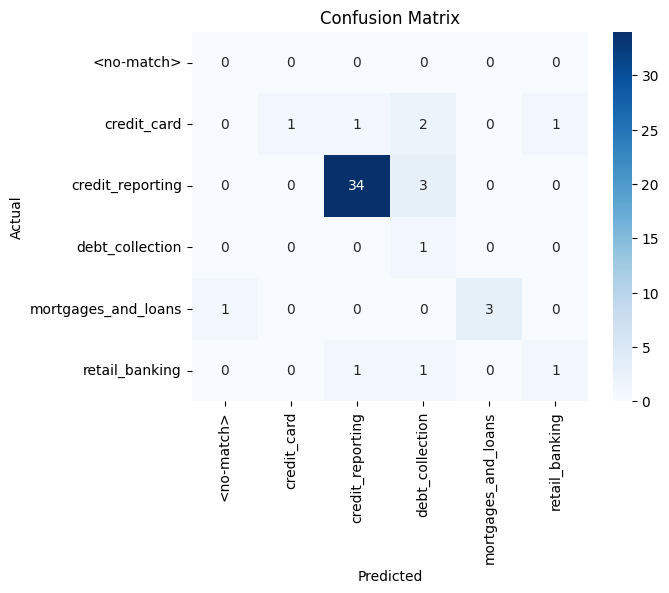

In [25]:
# Creating confusion matrix
cnf_mt = confusion_matrix(new_data['product'], new_data['mistral_response_cleaned'])

# Visualizing confusion matrix using a heatmap
num_cats = new_data['mistral_response_cleaned'].value_counts().shape[0]
if num_cats == 5:
  labels=['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
elif num_cats == 6:
  labels=['<no-match>','credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
    
sns.heatmap(cnf_mt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## **Few-Shot Prompting (6 Marks)**

### **Q16: Prepare examples for a few-shot prompt, formulate the prompt, and generate the Mistral response. (4 Marks)**

**Generate a set of gold examples by randomly selecting 10 instances of user_input and assistant_output from dataset ensuring a balanced representation with 2 examples from each class.**

In [26]:
# Separate product classifications by category
import json
review_1 = data[data['product'] == 'credit_card']
review_2 = data[data['product'] == 'retail_banking']
review_3 = data[data['product'] == 'credit_reporting']
review_4 = data[data['product'] == 'mortgages_and_loans']
review_5 = data[data['product'] == 'debt_collection']

# Sample 2 product classifications from each category for gold examples
gold_examples_1 = review_1.sample(2, random_state=40)
gold_examples_2 = review_2.sample(2, random_state=40)
gold_examples_3 = review_3.sample(2, random_state=40)
gold_examples_4 = review_4.sample(2, random_state=40)
gold_examples_5 = review_5.sample(2, random_state=40)

# Concatenate product classification examples
gold_examples_df = pd.concat([gold_examples_1,gold_examples_2,gold_examples_3,gold_examples_4,gold_examples_5 ])

# Create the training set by excluding gold examples
test_df = data.drop(index=gold_examples_df.index)

# Convert gold examples to JSON
columns_to_select = ['narrative', 'product']
gold_examples_json = gold_examples_df[columns_to_select].to_json(orient='records')

# Print the first record from the gold examples JSON
print("gold_example[0]: ", json.loads(gold_examples_json)[0])

# Print the shapes of the datasets
print("Test Set Shape:", test_df.shape)
print("Gold Examples Shape:", gold_examples_df.shape)

gold_example[0]:  {'narrative': 'called request new york state covid relief plan day interest fee waived amex provided relief leading late payment amex refused honor relief day gap insists charging late fee', 'product': 'credit_card'}
Test Set Shape: (490, 3)
Gold Examples Shape: (10, 3)


Define your **system_message**.

Define **first_turn_template**, **example_template** and **prediction template**

**create few shot prompt** using gold examples and system_message

Randomly select 50 rows from test_df as test_data

Create **mistral_response** and **mistral_response_cleaned** columns

In [27]:
system_message = """You are an AI evaluating the provided input text below to generate a singular product classification.
A singular product classification is exactly one of:
- credit_card
- retail_banking
- credit_reporting
- mortgages_and_loans
- debt_collection
Be concise. Respond only with a singular product classification as defined above.
Input text will be delimited by triple backticks."""

In [28]:
mistral_first_turn_template = """[INST]\n <<SYS>> \n{system_message}\n <</SYS>>```{user_message}```[/INST]{assistant_message}"""
mistral_examples_template = """[INST]```{user_message}```[/INST] {assistant_message}"""
mistral_prediction_template = """[INST]```{user_message}```[/INST]"""

In [29]:
def create_few_shot_prompt(_system_message, examples_df):

    """
    Return a prompt message in the format expected by Mistral 7b.
    10 examples are selected randomly as golden examples to form the
    few-shot prompt.
    We then loop through each example and parse the narrative as the user message
    and the product as the assistant message.

    Args:
        system_message (str): system message with instructions for classification
        examples(DataFrame): A DataFrame with examples (product + narrative + summary)
        to form the few-shot prompt.

    Output:
        few_shot_prompt (str): A prompt string in the Mistral format
    """

    few_shot_prompt = ''

    columns_to_select = ['narrative','product']

    examples = (
        examples_df.loc[:, columns_to_select].to_json(orient='records')
    )

    for idx, example in enumerate(json.loads(examples)):
        user_input_example = example['narrative']
        assistant_output_example = example['product']

        if idx == 0:
            few_shot_prompt += mistral_first_turn_template.format(
                system_message=_system_message,
                user_message=user_input_example,
                assistant_message=assistant_output_example
            )
        else:
            few_shot_prompt += mistral_examples_template.format(
                user_message=user_input_example,
                assistant_message=assistant_output_example
            )

    return few_shot_prompt

In [73]:
few_shot_prompt = create_few_shot_prompt(system_message, gold_examples_df)
#print(few_shot_prompt)

NameError: name 'create_few_shot_prompt' is not defined

In [31]:
def fs_generate_prompt(_few_shot_prompt, _user_input):
    _prompt =  _few_shot_prompt + mistral_prediction_template.format(user_message=_user_input)
                                 # ^^ accessing a global variable is generally considered bad form, but whatever
    return _prompt

In [32]:
def generate_mistral_response(_sys_prompt, _input_text):

    # Combine user_prompt and system_message to create the prompt
    prompt = fs_generate_prompt(_sys_prompt, _input_text)

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1200,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['/s'],
        echo=False
    )

    # Extract and return the response text
    response_text = response["choices"][0]["text"]
    return response_text

In [33]:
# Randomly select 50 rows
test_data = data.sample(n=50, random_state=40)

In [34]:
# capture lenthy model timing output to variable
%%capture gen_out
test_data['mistral_response'] = test_data['narrative'].apply(lambda x: generate_mistral_response(few_shot_prompt, x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     633.27 ms
llama_print_timings:      sample time =     618.40 ms /  1200 runs   (    0.52 ms per token,  1940.49 tokens per second)
llama_print_timings: prompt eval time =    2164.04 ms /  2078 tokens (    1.04 ms per token,   960.24 tokens per second)
llama_print_timings:        eval time =   38304.56 ms /  1199 runs   (   31.95 ms per token,    31.30 tokens per second)
llama_print_timings:       total time =   42880.56 ms /  3277 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     633.27 ms
llama_print_timings:      sample time =      55.04 ms /   106 runs   (    0.52 ms per token,  1925.94 tokens per second)
llama_print_timings: prompt eval time =     596.65 ms /   506 tokens (    1.18 ms per token,   848.07 tokens per second)
llama_print_timings:        eval time =    3348.56 ms /   105 runs   (   31.89 ms per token,    31.36 tokens per second)
llama_print_timings:       to

In [41]:
test_data['mistral_response_cleaned'] = test_data['mistral_response'].apply(lambda x: extract_category(x))


No match:   This text appears to be discussing various issues related to financial products and services, including identity theft, disputes with banks or credit card companies, and debt collection. Based on the context provided, it seems most relevant to the following product classifications:

* Credit reporting
* Retail banking
* Debt collection

However, without a clear and specific request for a singular product classification based on the text itself, I cannot definitively assign one label. Therefore, I will not provide an answer at this time.

No match:   This text appears to be discussing various issues related to financial products and services, including identity theft, disputes with banks or credit card companies, and debt collection. Based on the context provided, it seems most relevant to the following product classifications:

* Credit reporting
* Retail banking
* Debt collection

However, without a clear and specific request for a singular product classification based on

In [42]:
test_data['product'].value_counts()

product
credit_reporting       37
credit_card             7
mortgages_and_loans     4
retail_banking          1
debt_collection         1
Name: count, dtype: int64

In [43]:
test_data['mistral_response_cleaned'].value_counts()

mistral_response_cleaned
credit_reporting       27
debt_collection        12
mortgages_and_loans     4
                        3
retail_banking          2
credit_card             2
Name: count, dtype: int64

### **Calculate F1 score (1 Mark)**

In [44]:
# Calculate F1 score for 'product' and 'mistral_response_cleaned'
f1_3 =  f1_score(test_data['product'], test_data['mistral_response_cleaned'], average="micro")
print(f'F1 Score: {f1_3}')

F1 Score: 0.62


### **Q17: Share your observations on the few-shot and zero-shot prompt techniques. (1 Marks)**

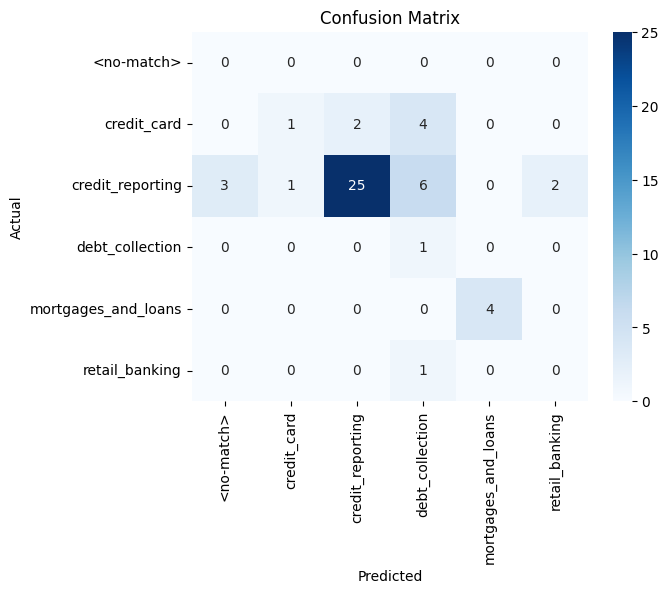

In [45]:
# Creating confusion matrix
cnf_mt = confusion_matrix(test_data['product'], test_data['mistral_response_cleaned'])

# Visualizing confusion matrix using a heatmap
num_cats = test_data['mistral_response_cleaned'].value_counts().shape[0]
if num_cats == 5:
  labels=['credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']
elif num_cats == 6:
  labels=['<no-match>','credit_card','credit_reporting','debt_collection','mortgages_and_loans','retail_banking']

sns.heatmap(cnf_mt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Section 4: Text to Text generation (5 Marks)**

## **Q18: Setup prompts (1 Mark)**

Define a **system message** as a string and assign it to the variable system_message to generate product class.** (1 Mark)**

Create a **zero shot prompt template** that incorporates the system message and user input.

Define **generate_prompt** function that takes both the system_message and user_input as arguments and formats them into a prompt template

In [55]:
system_message = """
Summarize the user input below. Be specific and concise in your summary.
"""

In [56]:
zero_shot_prompt_template = "[INST]\n<<SYS>>{system_message}<<SYS>>\n{user_input}\n[/INST]"

In [57]:
# Define function that combines user_prompt and system_message to create the prompt
def t2t_generate_prompt(_system_message, _user_input):
    _prompt = zero_shot_prompt_template.format(system_message=_system_message, user_input=_user_input)
    return _prompt

In [58]:
print(t2t_generate_prompt(system_message, "this is the user input"))

[INST]
<<SYS>>
Summarize the user input below. Be specific and concise in your summary.
<<SYS>>
this is the user input
[/INST]


Write a Python function called **generate_mistral_response** that takes a single parameter, narrative, which represents the user's complain. Inside the function, you should perform the following tasks:

- **Combine the system_message and narrative to create a prompt string using generate_prompt function.**

*Generate a response from the Mistral model using the lcpp_llm instance with the following parameters:*

- prompt should be the combined prompt string.
- max_tokens should be set to 1200.
- temperature should be set to 0.
- top_p should be set to 0.95.
- repeat_penalty should be set to 1.2.
- top_k should be set to 50.
- stop should be set as a list containing '/s'.
- echo should be set to False.
Extract and return the response text from the generated response.

Don't forget to provide a value for the system_message variable before using it in the function.

In [59]:
def t2t_generate_mistral_response(_sys_prompt, _input_text):

    # Combine user_prompt and system_message to create the prompt
    prompt = t2t_generate_prompt(_sys_prompt, _input_text)

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1200,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['/s'],
        echo=False
    )

    # Extract and return the response text
    response_text = response["choices"][0]["text"]
    return response_text

### **Q19: Generate mistral_response column containing LLM generated summaries** **(1 Marks)**

In [60]:
# Randomly select 50 rows
test_data = data.sample(n=50, random_state=40)

In [62]:
# capture lengthy model timing output to variable
%%capture gen_out
# apply generate_response function to each narrative in dataset
test_data['mistral_response'] = test_data['narrative'].apply(lambda x: t2t_generate_mistral_response(system_message, x))

In [64]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 167 to 387
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product           50 non-null     object
 1   narrative         50 non-null     object
 2   summary           50 non-null     object
 3   mistral_response  50 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


In [72]:
print("AI summary:  \n", test_data['mistral_response'].iloc[0])
print("\nReference summary:\n", test_data['summary'].iloc[0])

AI summary:  
  The user is reporting a fraudulent charge of an undisclosed amount on their Capital One checking account, which was made using a debit card. The charge was immediately canceled and the user disputed it with Capital One. A provisional credit was issued to the account pending determination of the claim. However, the bank denied the claim after receiving a form letter. Despite never losing possession of their debit card, someone else used it for a fraudulent purchase. The user believes the card was intercepted and activated without their authorization. They have contacted Capital One multiple times to discuss the original claim and make a determination. Additionally, they reported the incident to local police department's financial services division regarding the fraudulent charge. A replacement card has been sent but it was activated before receiving it, allowing for unauthorized credit purchases. The user is appealing the denial of their claim with Capital One and provid

### **Q20: Evaluate bert score** **(2 Marks)**

In [66]:
bert_scorer = evaluate.load("bertscore")
bscore = bert_scorer.compute(
            predictions=test_data['mistral_response'],
            references=test_data['summary'],
            lang="en",
            rescale_with_baseline=True
        );

score = sum(bscore['f1'])/len(bscore['f1']);
print(f'BERT Score: {score}')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Score: 0.35526664793491364


In [67]:
rouge_scorer = evaluate.load("rouge")
rscore = rouge_scorer.compute(
            predictions=test_data['mistral_response'],
            references=test_data['summary']
        )
print(f"Rouge Scores: {rscore}")

Rouge Scores: {'rouge1': 0.494803417891791, 'rouge2': 0.17045653366638597, 'rougeL': 0.291427956721481, 'rougeLsum': 0.30613231392609996}


### **Q21: Write your observation** **(1 Marks)**

- BERT score of .36 is at the low end of acceptable performance.